In [1]:
## Script for analyzing postture data
#coded almost entirely by Ammon's left hand

import os
import math
import numpy as np
import scipy as sp
from scipy.io import wavfile as wf
from scipy.signal import spectrogram
from scipy.stats import f_oneway

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import cm
from matplotlib import patches as mpatches
import datetime
import wave
import time


to get the data:

grab a list of the directories you want the files from:
ls -1a

copy it into a file:
cat >> processed_out.txt

scp each file:
cat processed_out.txt | xargs -i scp birds@kostas-ap.grasp.upenn.edu:/birds/postures/{}/postprocessed/out.txt ./processed_postures/{}.txt

to get the songs:

find . -name *.wav | grep -v  'audio.wav\|song.wav'
cat > song_list.txt


In [2]:
data_dir = './processed_postures/'
song_list = './song_list.txt'

mySongList = np.loadtxt(song_list, dtype=str, delimiter='/')
songDict = dict(zip(mySongList[:,1],mySongList[:,2]))

Data is of the form


time (s from trigger) | timestamp | E3 | E2 | E1 | angle from vertical (a post processed Eigen Vector 1)

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in true_divide


117.94849696666665 40.80919047083333
38.56965324791666
0


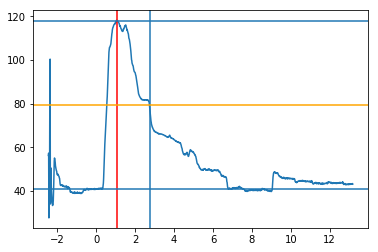

111.41577383333333 42.335142295833336
34.54031576875
1


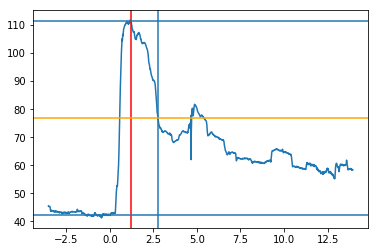

109.64597846666665 36.52580648125
36.56008599270832
2


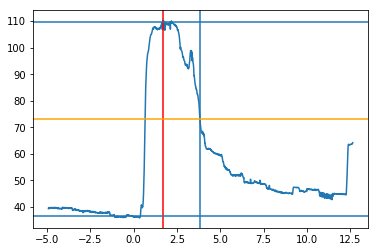

129.26273596666667 35.0507244625
47.106005752083334
3


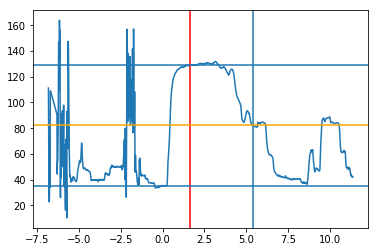

121.53309573333334 45.45370765208334
38.039694040625
4


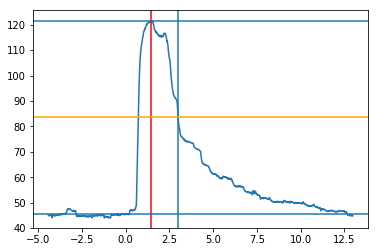

114.87369426666666 36.454296281249995
39.20969899270833
5


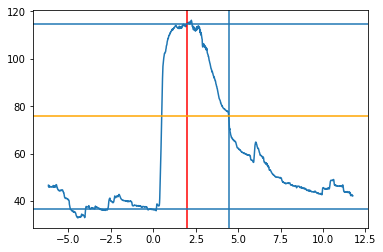

113.66797799999998 40.97436582708333
36.34680608645832
6


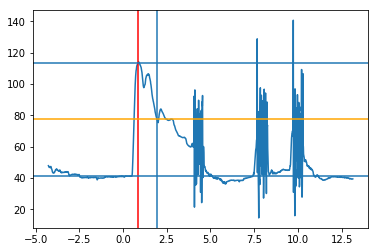

111.15139916666666 43.18816028958333
33.98161943854167
7


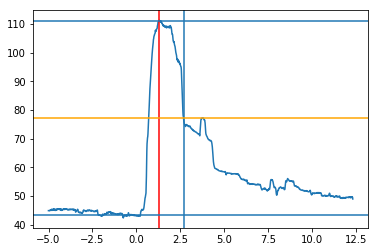

39.36429766666666 32.8947457
3.2347759833333285
8


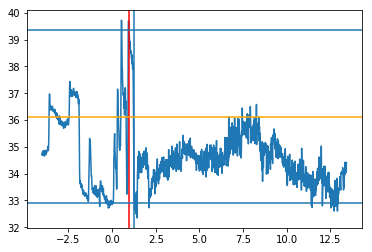

133.76193513333334 44.4861107375
44.63791219791667
9


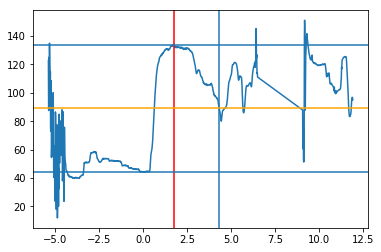

106.00593173333333 49.90625420222223
28.04983876555555
10


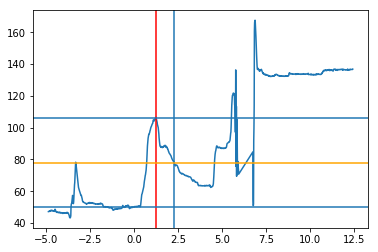

107.6198823 34.668243268888894
36.47581951555556
11


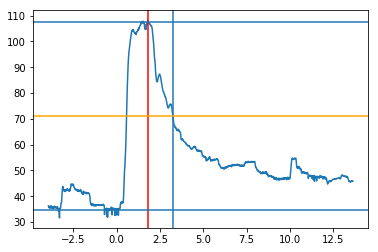

118.90157573333333 61.967257760416665
28.467158986458333
12


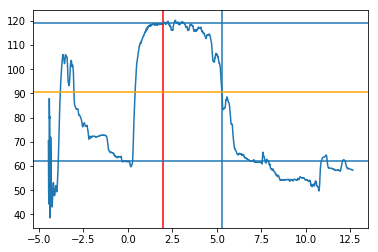

125.34374526666666 38.5496839875
43.39703063958333
13


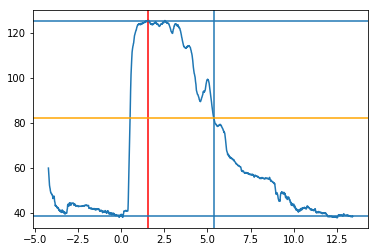

127.1031844 50.881940368749994
38.110622015625005
14


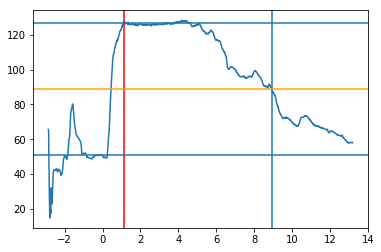

115.50971796666667 47.956899650000004
33.77640915833334
15


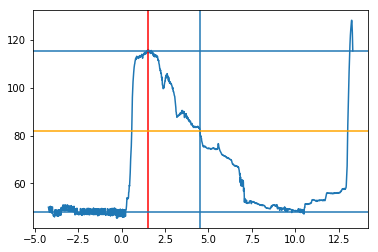

113.94943503333334 36.8005756625
38.574429685416675
16


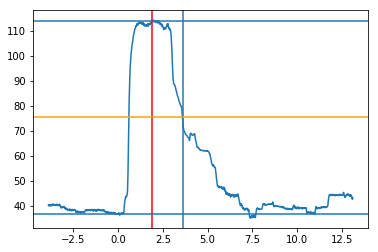

121.95817613333332 34.43002988541667
43.764073123958326
17


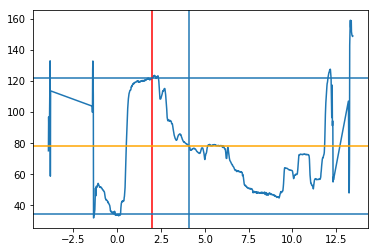

127.16399739999999 44.64850168541666
41.25774785729166
18


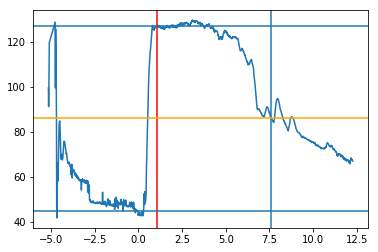

118.29675336666668 37.709823656249995
40.29346485520834
19


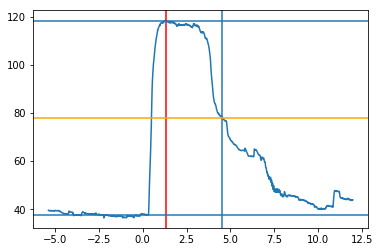

112.69243016666665 31.800775504166666
40.445827331249994
20


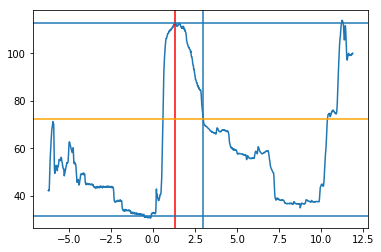

97.9606648 43.48011714583333
27.240273827083335
21


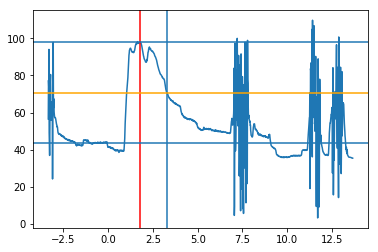

110.51028340000002 48.01300404791667
31.248639676041677
22


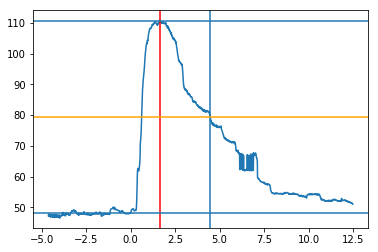

111.6971024 25.009591
43.3437557
23


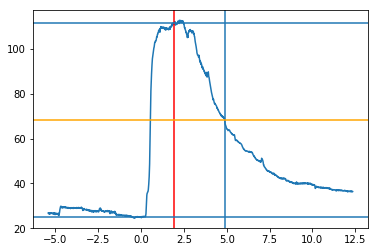

97.70135096666667 43.93308195
26.884134508333332
24


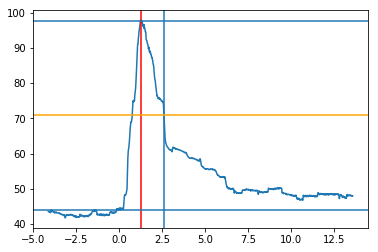

122.37743116666665 34.387487747916666
43.994971709374994
25


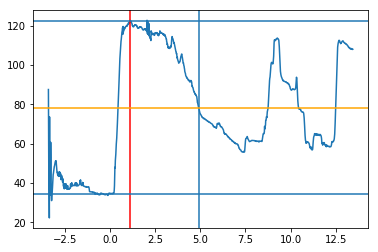

112.68492963333333 31.81910534791666
40.43291214270833
26


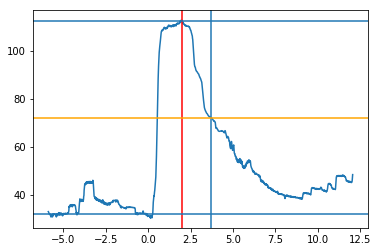

119.01896350000001 24.928694872916665
47.04513431354167
27


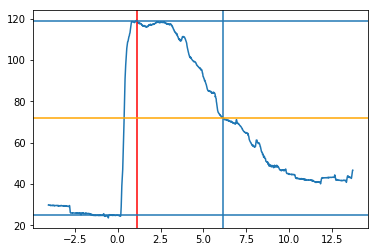

113.40837810000001 36.771121647916665
38.31862822604167
28


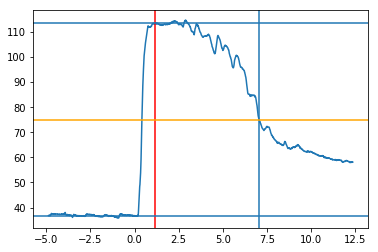

115.77182419999998 39.26269868823529
38.25456275588235
29


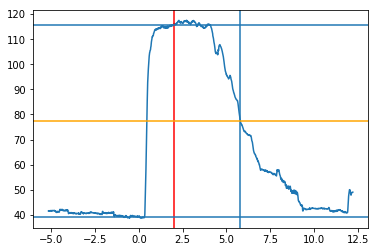

125.20137966666667 29.371927666666664
47.914726
30


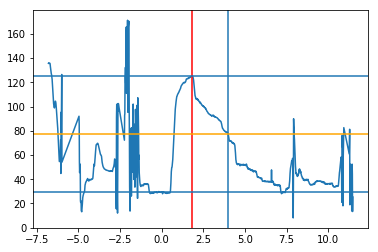

100.80495930000001 65.42664412916666
17.689157585416673
31


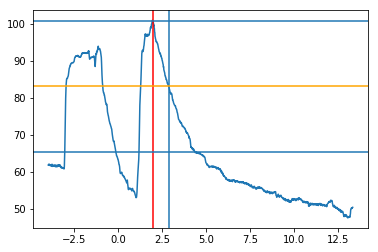

101.81914273333332 37.68546125208333
32.066840740625
32


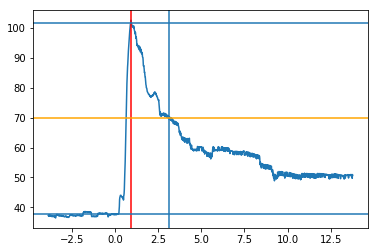

113.63345156666664 29.380234945833333
42.12660831041665
33


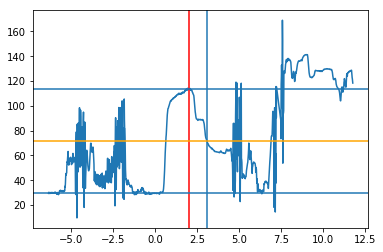

120.40827326666665 60.86073707916667
29.773768093749993
34


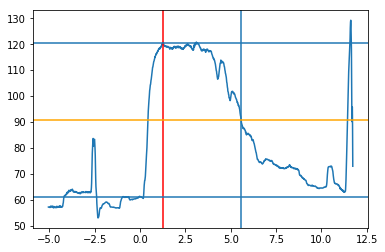

113.86978090000001 39.85671230625
37.006534296875
35


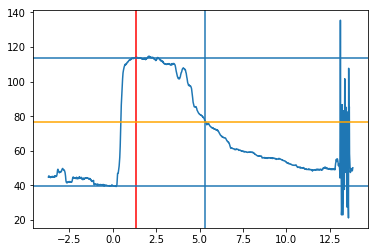

108.23707839999999 38.127235858333336
35.054921270833326
36


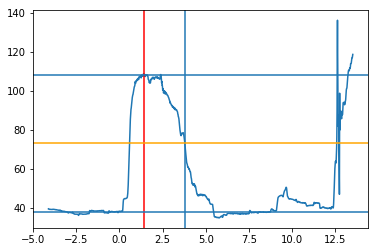

124.61594419999999 56.233860810416665
34.191041694791664
37


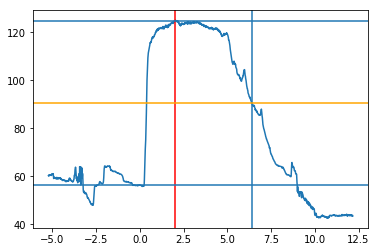

120.39826359999999 35.13515331666666
42.63155514166667
38


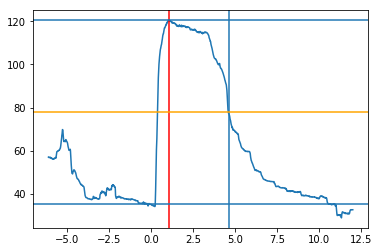

In [3]:
## Define sequence objects and read in data set, with a fair amount of processing and analysis
class Sequence:
    def __init__(self, data, seq_name = 'seq', song_name = 'song'):
        self.data = data
        self.seq_name = seq_name
        self.song_name = song_name
        self.date = 0
        self.timestamp = data[1,1]
        self.date = datetime.datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d')
        self.time = datetime.datetime.fromtimestamp(self.timestamp).strftime('%H:%M')
        self.hour = datetime.datetime.fromtimestamp(self.timestamp).hour
        kernel = np.array([1,2,3,5,8,5,3,2,1])
        kernel = kernel / kernel.sum()
        self.smooth_data = np.convolve(self.data[:,5],kernel,mode='same')
        self.ts = data[:,0]
        self.ys = data[:,5]
        self.vel = np.diff(self.ys)
        self.vel_smooth = np.diff(self.smooth_data)
        self.acc = np.diff(self.vel)   
        self.acc_smooth = np.diff(self.vel_smooth)
        self.bird = ''
        
        ## a bunch of values for plotting and standardizing
        
        ### Set Values that inform the duration
        BASELINE_P = 40
        PEAK_P = 125
        self.tzero = min(self.ts[self.ts >= 0])
        self.tzero_index = np.where(self.ts == self.tzero)
        
        #Baseline
        self.t_baseline = min(self.ts[self.ts >= -1.0])
        self.t_baseline_index = np.where(self.ts == self.t_baseline)
        #print(self.t_baseline_index)
        
        # first motion:
        self.baseline = np.mean(self.smooth_data[np.logical_and(self.ts >= -.2,self.ts <= 0.0)])
        self.baseline_std = np.std(self.smooth_data[np.logical_and(self.ts >= -.2,self.ts <= 0.0)])
        
        #first_motion_index = np.argmax(self.smooth_data > (baseline + 2 * baseline_std))
        first_motion_index = np.argmax(np.logical_and(self.ts > 0, self.smooth_data > (self.baseline + 10 * self.baseline_std)))
        
        first_motion = self.ts[first_motion_index]
        #print(first_motion_index,first_motion)
        self.t_latency = first_motion
        self.t_latency_index = first_motion_index
        
        # upswoop range:
        reaction_range = (self.ts > 0) & (self.ts < 2)
        acc_reaction_window = self.acc_smooth[reaction_range[:-2]]
        self.peak_acc = max(acc_reaction_window)
        self.peak_acc_index = np.where(self.acc_smooth == self.peak_acc)
        
        vel_reaction_window = self.vel_smooth[reaction_range[:-1]]
        self.peak_vel = max(vel_reaction_window)
        self.peak_vel_index = np.where(self.vel_smooth == self.peak_vel)
        #self.t_latency = self.ts[self.peak_vel_index]
        self.t_peak_vel = self.ts[self.peak_vel_index]
        
        # Stabilization (defined as the first non-positive velocity following v_max)
        neg_vel = np.where(self.vel_smooth <= 0)[0]
        self.stable_vel_index = neg_vel[neg_vel > self.peak_vel_index[0]][0]
        self.t_stable_vel = self.ts[self.stable_vel_index]
        
        # peak angle
        self.peak_angle = max(self.smooth_data[reaction_range])
        #self.peak_angle_index = np.argmax(self.smooth_data[reaction_range])
        self.peak_angle_index = np.where(self.smooth_data == self.peak_angle)
        self.t_peak = self.ts[self.peak_angle_index]
        
        # refraction
        refraction_range = self.smooth_data[self.ts > self.ts[self.peak_angle_index]]

        half_peak = self.peak_angle - (self.peak_angle - self.baseline) / 2
        self.half_peak = half_peak
        #half_peak = PEAK_P - (PEAK_P - BASELINE_P) / 2
        refraction_index_fake = np.argmax(refraction_range < half_peak)
        self.refraction_value = refraction_range[refraction_index_fake]
        self.refraction_index = np.where(self.smooth_data == self.refraction_value)
        self.t_refraction = self.ts[self.refraction_index]
        
        self.duration = np.asscalar(self.t_refraction - self.t_latency)
        self.stretch_time()
        self.shadow = self.get_shadow(self.stretched_angle)
        baseline_e2 = self.stretched_e2[np.where(self.stretch_time == 0)]
        self.shadow_e2 = self.get_shadow(self.stretched_e2, baseline_p = 0)
        
    def stretch_time(self):
        tb_p = -1.0
        ts_p = 0.0
        t0_p = 0.250
        t1_p = 0.500
        t2_p = 1.0
        t3_p = 4.0
        t4_p = 12.0
        
        myseq = self
        #print(myseq.t_latency, myseq.t_peak, myseq.duration)
        mydata = myseq.smooth_data
        mytime = myseq.ts
        
        tb = mytime[myseq.t_baseline_index]
        ts = mytime[myseq.tzero_index]
        t0 = mytime[myseq.t_latency_index]
        t1 = mytime[myseq.peak_vel_index]
        t2 = mytime[myseq.stable_vel_index]
        t3 = mytime[myseq.refraction_index]
        t4 = mytime[len(myseq.ts) - 1]
        """
        phase0 = mydata[myseq.tzero_index:myseq.peak_vel_index] #zero to latency
        phase1 = mydata[myseq.peak_vel_index,myseq.peak_angle_index] #latency to peak
        phase2 = mydata[myseq.peak_angle_index,myseq.refraction_index] #peak to refractcion

        """
        phaseB_time_indices = np.where(np.logical_and(mytime>=tb,mytime<=ts))
        phaseS_time_indices = np.where(np.logical_and(mytime>=ts,mytime<=t0))
        phase0_time_indices = np.where(np.logical_and(mytime>=t0,mytime<=t1))
        phase1_time_indices = np.where(np.logical_and(mytime>=t1,mytime<=t2))
        phase2_time_indices = np.where(np.logical_and(mytime>=t2,mytime<=t3))
        phase3_time_indices = np.where(np.logical_and(mytime>=t3,mytime<=t4))

        phaseB_time = mytime[phaseB_time_indices]
        phaseS_time = mytime[phaseS_time_indices]
        phase0_time = mytime[phase0_time_indices]
        phase1_time = mytime[phase1_time_indices]
        phase2_time = mytime[phase2_time_indices]
        phase3_time = mytime[phase3_time_indices]

        self.phaseB_time = phaseB_time
        self.phaseS_time, self.phase0_time, self.phase1_time = phaseS_time, phase0_time, phase1_time 
        self.phase2_time, self.phase3_time = phase2_time, phase3_time
        
        self.phaseB = mydata[phaseB_time_indices]
        self.phaseS = mydata[phaseS_time_indices]
        self.phase0 = mydata[phase0_time_indices]
        self.phase1 = mydata[phase1_time_indices]
        self.phase2 = mydata[phase2_time_indices]
        self.phase3 = mydata[phase3_time_indices]
        
        ## Same stuff, but for the 2nd eigen value (puffing)
        self.e2_phaseB = self.data[:,3][phaseB_time_indices]
        self.e2_phaseS = self.data[:,3][phaseS_time_indices]
        self.e2_phase0 = self.data[:,3][phase0_time_indices]
        self.e2_phase1 = self.data[:,3][phase1_time_indices]
        self.e2_phase2 = self.data[:,3][phase2_time_indices]
        self.e2_phase3 = self.data[:,3][phase3_time_indices]
    
        # transform t0 -> 0, t1 -> .5
        self.phaseB_time_stretched = self.phaseB_time
        self.phaseS_time_stretched = (phaseS_time - ts) / (t0 - ts) * (t0_p - ts_p) + ts_p
        self.phase0_time_stretched = (phase0_time - t0) / (t1 - t0) * (t1_p - t0_p) + t0_p # figure percentage, multiply by range, add to start
        self.phase1_time_stretched = (phase1_time - t1) / (t2 - t1) * (t2_p - t1_p) + t1_p
        self.phase2_time_stretched = (phase2_time - t2) / (t3 - t2) * (t3_p - t2_p) + t2_p
        self.phase3_time_stretched = (phase3_time - t3) / (t4 - t3) * (t4_p - t3_p) + t3_p

        self.stretched_time = np.concatenate((self.phaseB_time_stretched,self.phaseS_time_stretched,self.phase0_time_stretched,
                                              self.phase1_time_stretched, self.phase2_time_stretched,
                                              self.phase3_time_stretched))
        
        self.stretched_angle = np.concatenate((self.phaseB,self.phaseS,self.phase0,self.phase1,self.phase2,self.phase3))
        self.stretched_e2 = np.concatenate((self.e2_phaseB,self.e2_phaseS,self.e2_phase0,self.e2_phase1,self.e2_phase2,self.e2_phase3))
        
    def get_shadow(self,trajectory,baseline_p = 40):
        BASELINE_P = 40
        PEAK_P = 125        
        bins = np.arange(0,4,.05)
        shadow = 0
        for b in bins:
            val, index = find_nearest(self.stretched_time, b)
            #print(b, val, index)
            shadow += trajectory[index] - baseline_p
        return shadow
    
    
    def plot_angle(self, rgba = False,smooth = False, stretch = False):
        if stretch == True:
            ys = self.stretched_angle
            ts = self.stretched_time
        elif smooth == True:
            ys = self.smooth_data
            ts = self.ts
        else:
            ys = self.data[:,5]
            ts = self.ts
        if rgba != False:
            plt.plot(ts,ys, color = rgba, alpha = .5)
        else:
            plt.plot(ts,ys)
            
    def plot_lines(self,stretch=False):
        if stretch:
            t0 = 0.0   # Song is played
            t1 = 0.250 # First latency
            t2 = 0.500 # VMax
            t3 = 1.0   # V Stable
            t4 = 4.0   # Back to half peak

        else:
            t0 = self.tzero
            t1 = self.t_latency
            t2 = self.t_peak_vel
            t3 = self.t_stable_vel
            t4 = self.t_refraction

        #plt.axvline(t0)
        #plt.axvline(self.ts[self.peak_acc_index]
        plt.axvline(t1)
        plt.axvline(t2,color='r')
        plt.axvline(t3,color='g')
        plt.axvline(t4)
            
    def plot_e1(self):
        plt.plot(self.data[:,0],self.data[:,4])
        
    def plot_e2(self, rgba = False):
        if rgba == False:
            plt.plot(self.data[:,0],self.data[:,3])
        else:
            plt.plot(self.data[:,0],self.data[:,3], color = rgba, alpha = .5)
        
    def plot_e3(self):
        plt.plot(self.data[:,0],self.data[:,2])

## little function to get the nearest value and index from an array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

## List of all the sequences (minus the ones with 'm' in the name for now)
seqs = []
for seq_file in os.listdir(data_dir):
    if '2018' in seq_file:
        #print(seq)
        file_path = data_dir + seq_file
        seq_name = seq_file.split('.')[0]
        seq_data = np.genfromtxt(file_path)
        song_name = songDict[seq_name]
        Seq = Sequence(seq_data,seq_name,song_name)
        #print(Seq.song_name)
        if 'm' in Seq.song_name:
            #print(Seq.song_name)
            seqs.append(Seq)
            pass
        else:
            seqs.append(Seq)

if True:
    count = 0
    for seq in seqs:
        plt.cla()
        seq.plot_angle(stretch=False)
        #seq.plot_lines(stretch=True)
        
        #plt.plot(seq.ts[:-1],seq.vel_smooth)
        #plt.axvline(seq.t_peak_vel,color='r')
        #plt.axvline(seq.t_latency)
        #plt.axvline(seq.t_stable_vel,color='g')
        plt.axvline(seq.t_refraction)
        plt.axvline(seq.t_peak,color='r')
        plt.axhline(seq.baseline)
        plt.axhline(seq.peak_angle)
        plt.axhline(seq.half_peak,color='orange')
        print(seq.peak_angle,seq.baseline)
        print((seq.peak_angle-seq.baseline)/2)
        print(count)
        count +=1
        plt.show()


In [4]:
a = 28
b = 19
c = 36


print("latency to first movement:")
print("(High  -  Medium  -  Low)")
print(seqs[a].t_latency,seqs[b].t_latency,seqs[c].t_latency)
print("latency to vmax")
print(seqs[a].t_peak_vel,seqs[b].t_peak_vel,seqs[c].t_peak_vel)
[]

latency to first movement:
(High  -  Medium  -  Low)
0.205363 0.347453 0.184201
latency to vmax
[0.39271] [0.485233] [0.596159]


[]

In [5]:
## Simple function to convert pixel width/height to inches at a set dpi
def get_size(pixel_w,pixel_h, dpi= 300):
    w = pixel_w / dpi
    h = pixel_h / dpi
    return w,h

w,h = get_size(2202,1350)

In [6]:
def plot_scaled_wav(file_name = './playback_songs/BDY.wav',peak = 1,x_offset = 0, y_offset = 0,rgb='black',a_value=.5):

    fs, data = wf.read('./playback_songs/BDY.wav')
    scale = peak / max(data)
    data = data * scale + y_offset

    xs = np.linspace(x_offset,x_offset + len(data)/fs,num=len(data))
    plt.plot(xs, data, color = rgb, alpha = a_value)

#plot_scaled_wav(x_offset = -1)

In [7]:
# Handy function to graph spectrogram
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    #plt.cla()
    fig = plt.figure('transparent test')
    fig.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    
    #plt.title('spectrogram of %r' % wav_file)
    ax.specgram(sound_info, Fs = frame_rate, vmin = 10, cmap = 'viridis')
    
    #plt.xlim([3.5,5.5])
    #plt.show()
    #fig.savefig('./figures/Spectrogram_t.png')
    return fig, ax

# Quickly grab wav info (using wavfile from scipy.io)
def get_wav_info(wav_file):
    frames, data = wf.read(wav_file)
    if len(np.shape(data)) == 2:
        # File is stero
        sound_info = data[:,0]
    else:
        sound_info = data

    return sound_info, frames
#rcParams.update({'font.size': 14})

# Some quick plotting if you want it.
if False: 
    song = './playback_songs/'
    from matplotlib import rcParams
    fig, ax = graph_spectrogram('./playback_songs/originals/BOD.wav')
    rcParams.update({'font.size': 14})
    w,h = get_size(2202,1350)
    print(w,h)
    fig.set_size_inches(w,h)


    ax.set_xlabel('time (s)')
    ax.set_ylabel('frequency (Hz)')
    fig.tight_layout()
    fig.show()
    #fig.savefig('./figures/Spectrogram_t.png',dpi=300)

In [8]:
# set up color dicts, etc for Plotting:
songs_ordered = ['BDY.wav','BOD.wav','DMG.wav','LB.wav','LB-.wav','BDY-.wav']

songs = songs_ordered
#songs = sorted(set(seq.song_name for seq in seqs))
songs = songs_ordered
song_colors = list(list(cm.viridis(int(c * 255 / len(songs)))) for c in range(len(songs)))

#color_dict = dict(zip(songs,mcolors.BASE_COLORS.keys()))
songColors = dict(zip(songs,song_colors))

dates = sorted(set(seq.date for seq in seqs))
date_colors = list(list(cm.viridis(int(c * 255 / len(dates)))) for c in range(len(dates)))
dateColors = dict(zip(dates, date_colors))

hours = sorted(set(seq.hour for seq in seqs))
hour_colors = list(list(cm.viridis(int(c * 255 / len(hours)))) for c in range(len(hours)))
hourColors = dict(zip(hours,hour_colors))

# default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
p_colors = prop_cycle.by_key()['color']

# Jet colors
t_colors = list(list(cm.jet(int(c * 255 / 10))) for c in range(10))

print(p_colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


## Analysis Below: 
 - Variability of Peak Angle
 - Variability of Latency
 - Variability of Shape -> ADD non time-normalized. want to be careful of artifacts here
 - Involvement of different body parts (maybe offline...)
 - Involvement of the Cloaca (definitely off line)
 - Significance of Cloaca wrt Song Potency
 - Mean Latency
 - Difference between High and Low potency song latency
 - Mean Duration 
 - High v Low Duration
 - Plus v Minus Duration
 - Stereotypy of body parts using key points.

Peak angle distribution: 113.52024144871794 14.585769230410898


<IPython.core.display.Javascript object>


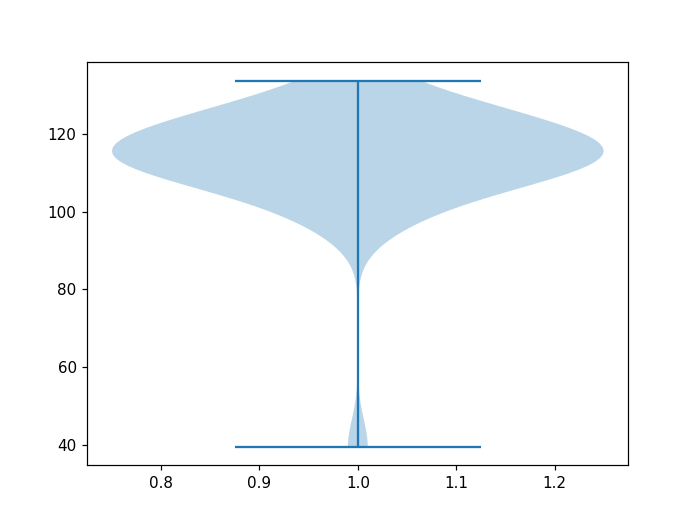

In [10]:
## Variability of Peak Angle: 
peaks = np.zeros(len(seqs))
latencies = np.zeros(len(seqs))
vmaxes = np.zeros_like(peaks)

for s in range(len(seqs)):
    seq = seqs[s]
    peaks[s] = seq.peak_angle
    latencies[s] = seq.t_latency
    vmaxes[s] = seq.t_peak_vel
    
print('Peak angle distribution:',peaks.mean(),peaks.std())

fig, ax = plt.subplots()
ax.violinplot(peaks)
fig.show()

<IPython.core.display.Javascript object>


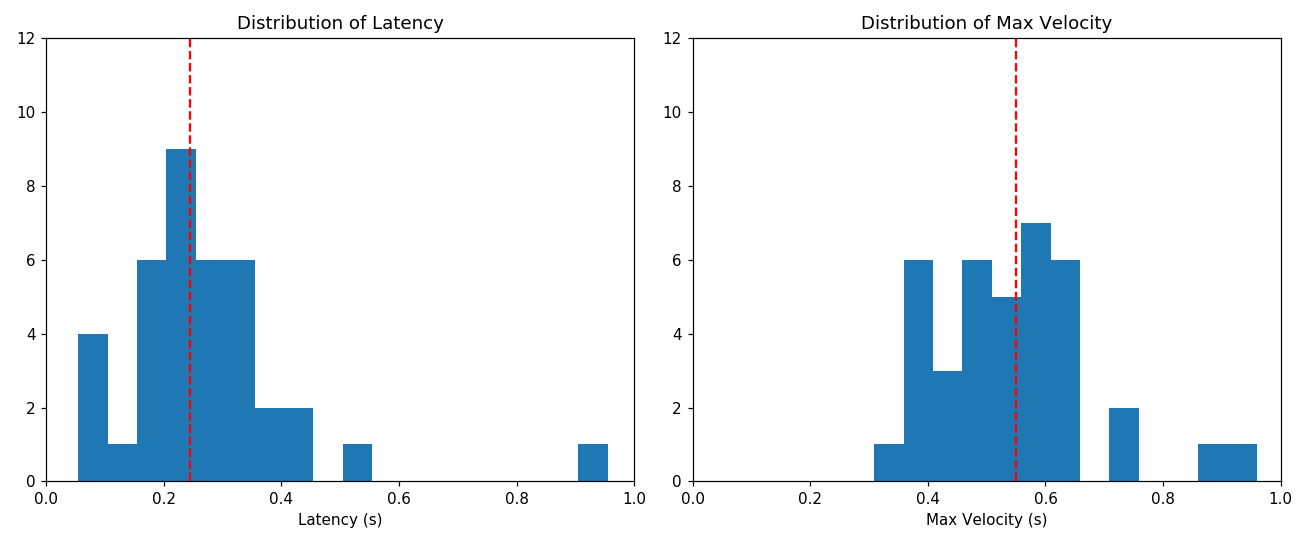

latencies: 0.24505 0.21654462090831256
vmaxes: 0.54958 0.17031912951685155


In [28]:
## Variability of Latency
%matplotlib notebook
fig, (ax1,ax2) = plt.subplots(1,2)
#ax1.violinplot(latencies)
#ax2.violinplot(vmaxes)
binwidth = .050
ax1.hist(latencies,bins=np.arange(min(latencies), max(latencies) + binwidth, binwidth))
ax1.set_xlim([0,1])
ax1.set_ylim([0,12])
ax1.axvline(np.median(latencies),color = 'r', linestyle='--')

ax2.hist(vmaxes,bins=np.arange(min(vmaxes), max(vmaxes) + binwidth, binwidth))
ax2.axvline(np.median(vmaxes),color = 'r', linestyle='--')
ax2.set_xlim([0,1])
ax2.set_ylim([0,12])

ax1.set_title('Distribution of Latency')
ax2.set_title('Distribution of Max Velocity')

ax1.set_xlabel('Latency (s)')
ax2.set_xlabel('Max Velocity (s)')


fig.patch.set_alpha(0)
ax1.patch.set_alpha(1)
ax2.patch.set_alpha(1)
fig.set_size_inches([12,5])
fig.tight_layout()
fig.show()
fig.savefig('/home/ammon/Desktop/SfNFigs/latencies.svg')

print('latencies:',np.median(latencies),latencies.std())
print('vmaxes:',np.median(vmaxes),vmaxes.std())

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


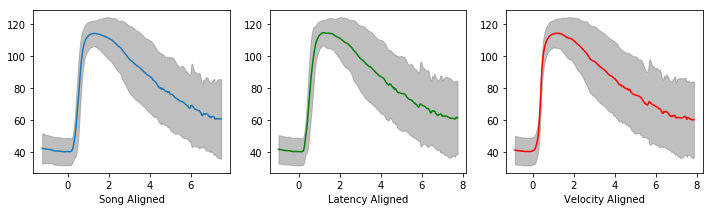

In [58]:
# Curve Deviation (aligned to song onset)
from scipy.ndimage.filters import gaussian_filter

song_aligned = np.zeros([len(seqs),700])
latency_aligned = np.zeros_like(song_aligned)
velocity_aligned = np.zeros_like(song_aligned)

for s in range(len(seqs)):
    song_anchor, = seqs[s].tzero_index
    latency_anchor = seqs[s].t_latency_index
    velocity_anchor, = seqs[s].peak_vel_index
    song_anchor, latency_anchor, velocity_anchor = int(song_anchor),int(latency_anchor),int(velocity_anchor)
    song_aligned[s,:] = seqs[s].smooth_data[song_anchor - 100:song_anchor + 600]
    latency_aligned[s,:] = seqs[s].smooth_data[latency_anchor - 100:latency_anchor + 600]
    velocity_aligned[s,:] = seqs[s].smooth_data[velocity_anchor - 100:velocity_anchor + 600]

ts = seqs[s].ts[song_anchor-100:song_anchor + 600]
tl = seqs[s].ts[latency_anchor-100:latency_anchor + 600]
tv = seqs[s].ts[velocity_anchor-100:velocity_anchor + 600]


fig,(ax1,ax2,ax3) = plt.subplots(1,3)
song_mean,song_std = song_aligned.mean(0),song_aligned.std(0)
lat_mean,lat_std = latency_aligned.mean(0),latency_aligned.std(0)
vel_mean,vel_std = velocity_aligned.mean(0),velocity_aligned.std(0)

ax1.plot(ts,song_mean)
ax1.fill_between(ts,song_mean + song_std,song_mean - song_std,alpha = .5,color='gray')
ax1.set_xlabel('Song Aligned')

ax2.plot(tl,lat_mean,color='green')
ax2.fill_between(tl,lat_mean + lat_std,lat_mean - lat_std,alpha = .5,color='gray')
ax2.set_xlabel('Latency Aligned')

ax3.plot(tv,vel_mean,color='red')
ax3.fill_between(tv,vel_mean + vel_std,vel_mean - vel_std,alpha = .5,color='gray')
ax3.set_xlabel('Velocity Aligned')

fig.set_size_inches(12,3)
fig.show()


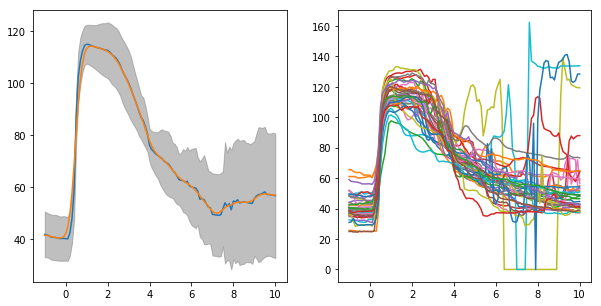

In [57]:
# Curve deviation (time stretched): 
from scipy.ndimage.filters import gaussian_filter


standard_curves = np.zeros([111,len(seqs)])
for s in range(len(seqs)):
    seq = seqs[s]
    s_time = seq.stretched_time[seq.stretched_time >= -1]
    s_angle = seq.stretched_angle[seq.stretched_time >= -1]
    s_angle = s_angle[s_time < 10]
    s_time = s_time[s_time < 10]
    s_time = s_time.round(1) * 10 + 10
    for a in range(len(s_angle)):
        index = int(s_time[a])
        standard_curves[index,s] = s_angle[a]
    #tandard_curves[:,s] = gaussian_filter(standard_curves[:,s],sigma=2)
    
mean_curve = standard_curves.mean(1)
std_curve = standard_curves.std(1)
error_plus = mean_curve + std_curve
error_minus = mean_curve - std_curve

smooth_mean = gaussian_filter(mean_curve, sigma = 2)
smooth_plus = gaussian_filter(error_plus, sigma = 2)
smooth_minus = gaussian_filter(error_minus, sigma = 2)


fig,(ax,ax2) = plt.subplots(1,2)
xs = np.linspace(-1,10,111)
ax.plot(xs,mean_curve)
ax.plot(xs,smooth_mean)
#ax.plot(xs,smooth_plus)
#ax.plot(xs,smooth_minus)
ax.fill_between(xs,error_plus,error_minus,alpha = .5,color='gray')

for n in range(len(seqs)):
    ax2.plot(xs,standard_curves[:,n])
    
fig.set_size_inches(10,5)

bdys = []

"""
## Maybe we want to just look at BDY, but it turns out this is mostly unrelated to song type regardless.
## That itself might be something to add: temporal variance, but little spatial variability.
for s in range(len(seqs)):
    if seqs[s].song_name == 'BDY.wav':
        bdys.append(s)
        ax.plot(xs,standard_curves[:,s])
        
print(bdys)
"""   
pass

# Cloaca involvement

Of the 57 postures, only 9 showed cloacal involvement. There did not seem to be a clear association with cloaca movement and song potency (ANOVA showed no difference), but given the very small sample size, it's difficult to draw any conclusions from this. 

In [79]:
# get all stats for positive negative songs:
highs = ['BDY.wav','BOD.wav']
lows = ['DMG.wav','LB.wav']

lats = [[],[]]
vels = [[],[]]
durs = [[],[]]
shas = [[],[]]
angs = [[],[]]
seqs_high = []
seqs_low = []
for seq in seqs:
    if seq.song_name in highs:
        seqs_high.append(seqs)
        lats[1].append(seq.t_latency)
        vels[1].append(seq.t_peak_vel)
        durs[1].append(seq.duration)
        shas[1].append(seq.shadow)
        angs[1].append(seq.peak_angle)

    elif seq.song_name in lows:
        seqs_low.append(seqs)
        lats[0].append(seq.t_latency)
        vels[0].append(seq.t_peak_vel)
        durs[0].append(seq.duration)
        shas[0].append(seq.shadow)
        angs[0].append(seq.peak_angle)
    else:
        pass
    
print(lats)
print('Latency:',sp.stats.ttest_ind(lats[1],lats[0]))
print('Max Velocity:',sp.stats.ttest_ind(vels[1],vels[0]))
print('Duration:',sp.stats.ttest_ind(durs[1],durs[0]))
print('Shadow:',sp.stats.ttest_ind(shas[1],shas[0]))
print('Peak Angle:',sp.stats.ttest_ind(angs[1],angs[0]))

[[0.40477, 0.231705, 0.190279, 0.386484, 0.363385, 0.33105, 0.304569, 0.291491, 0.51611, 0.184201], [0.242061, 0.270517, 0.26141, 0.33706, 0.347453, 0.055212, 0.063984, 0.174771, 0.205363, 0.312157, 0.216142, 0.24505, 0.255327]]
Latency: Ttest_indResult(statistic=-2.244022209151316, pvalue=0.035737697599712945)
Max Velocity: Ttest_indResult(statistic=array([-4.1753921]), pvalue=array([0.00042718]))
Duration: Ttest_indResult(statistic=4.12606494266061, pvalue=0.0004806720855946758)
Shadow: Ttest_indResult(statistic=2.2790250342489444, pvalue=0.033227780275591)
Peak Angle: Ttest_indResult(statistic=1.1821840639832168, pvalue=0.25034617467393355)


In [ ]:
# Functions for Fancier Stats if we want them: 1-way ANOVA followed by a Tukey Test

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

songs_ordered = ['BDY.wav','BOD.wav','DMG.wav','LB.wav','LB-.wav','BDY-.wav']

def get_dots(seqs,independents,ind_variable='song',dep_variable='latency'):
    latencies = []
    durations = []

    data_dict = {k : [] for k in independents}
    ys_dict = {k : [] for k in independents}
    data_index = dict(zip(independents,np.arange(1,len(independents)+1)))
    data_point = ''
    ind_point = ''
    for seq in seqs:
        if ind_variable == 'song':
            ind_point = seq.song_name
        elif ind_variable == 'date':
            ind_point = seq.date
        elif ind_variable == 'hour':
            ind_point = seq.hour
            
        ## Multiply by 1000 to put it in ms if you want that (for the short timescales, e.g.)
        if dep_variable == "latency":
            data_point = np.asscalar(seq.t_latency) * 1000
        if dep_variable == "peak":
            data_point = seq.peak_angle
        if dep_variable == "stable":
            data_point = np.asscalar(seq.t_stable_vel) * 1000
        elif dep_variable == "vmax":
            data_point = np.asscalar(seq.t_peak_vel) * 1000
        elif dep_variable == "duration":
            data_point = seq.duration
        elif dep_variable == "shadow":
            data_point = seq.shadow / 60
        elif dep_variable == "shadow_e2":
            data_point = seq.shadow_e2
            
        data_dict[ind_point].append(data_point)
    
    return data_dict

In [88]:
## Choose your dependent variabile of interest (e.g. VMAX): 

data_dict = get_dots(seqs,songs_ordered,dep_variable='vmax')

data_1d = []
groups_1d = []
for k in data_dict.keys():
    for v in data_dict[k]:
        data_1d.append(v)
        groups_1d.append(k)
#print(data_1d,groups_1d)
        
print(f_oneway(data_dict['BDY.wav'],data_dict['BOD.wav'],
               data_dict['DMG.wav'],data_dict['LB.wav'],
               data_dict['LB-.wav'],data_dict['BDY-.wav']))
print(pairwise_tukeyhsd(data_1d,groups_1d))

F_onewayResult(statistic=5.791592748547705, pvalue=0.000740337254079329)
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2 meandiff   lower    upper   reject
---------------------------------------------------
BDY-.wav BDY.wav -52.5523 -195.3041 90.1995  False 
BDY-.wav BOD.wav -62.1466 -209.7718 85.4787  False 
BDY-.wav DMG.wav 57.0761  -106.4666 220.6188 False 
BDY-.wav LB-.wav  71.181   -67.8036 210.1656 False 
BDY-.wav  LB.wav 136.1343  -11.491  283.7595 False 
BDY.wav  BOD.wav -9.5943  -145.2294 126.0408 False 
BDY.wav  DMG.wav 109.6284  -43.1783 262.435  False 
BDY.wav  LB-.wav 123.7332  -2.4427  249.9092 False 
BDY.wav   LB.wav 188.6865  53.0514  324.3216  True 
BOD.wav  DMG.wav 119.2227  -38.1464 276.5917 False 
BOD.wav  LB-.wav 133.3275   1.6631  264.992   True 
BOD.wav   LB.wav 198.2808  57.5257  339.036   True 
DMG.wav  LB-.wav 14.1049  -135.1885 163.3983 False 
DMG.wav   LB.wav 79.0582   -78.3109 236.4272 False 
LB-.wav   LB.wav 64.9533   -66.7111 196.617

In [86]:
from matplotlib import rcParams
#rcParams.update({'font.size': 14})

def dot_plots(seqs, independents, ind_variable = 'song', dep_variable = 'latency', saves = False):
    latencies = []
    durations = []

    data_dict = {k : [] for k in independents}
    ys_dict = {k : [] for k in independents}
    data_index = dict(zip(independents,np.arange(1,len(independents)+1)))
    data_point = ''
    ind_point = ''
    for seq in seqs:
        if ind_variable == 'song':
            ind_point = seq.song_name
        elif ind_variable == 'date':
            ind_point = seq.date
        elif ind_variable == 'hour':
            ind_point = seq.hour
            
        if dep_variable == "latency":
            data_point = np.asscalar(seq.t_latency) * 1000
        if dep_variable == "peak":
            data_point = seq.peak_angle
        elif dep_variable == "vmax":
            data_point = np.asscalar(seq.t_peak_vel) * 1000
        elif dep_variable == "duration":
            data_point = seq.duration
        elif dep_variable == "shadow":
            data_point = seq.shadow / 60
        elif dep_variable == "shadow_e2":
            data_point = seq.shadow_e2
            
        data_dict[ind_point].append(data_point)
        location = data_index[ind_point]
        ys_dict[ind_point].append(location)
        
    fig = plt.figure('dot plot')
    fig.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)

    labels, data = [*zip(*data_dict.items())]
    y_labels, ys = [*zip(*ys_dict.items())]
    print(data[0],ys[0])

    ax.boxplot(data)
    
    for n in range(len(ys)):
        ax.scatter(ys[n],data[n],alpha=.7,s=11)
    
    print(np.shape(data),np.shape(ys))
    #ax.scatter(data,ys)
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    
    ax.set_ylim(0)

    if saves:
        fig.savefig('./figures/latency_whiskers.png')
    
    return fig,ax

dict_keys(['BDY.wav', 'BOD.wav', 'DMG.wav', 'LB.wav', 'LB-.wav', 'BDY-.wav'])


In [18]:
## Plot by song
rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)
for seq in seqs:
    color = songColors[seq.song_name]
    seq.plot_angle(color,stretch = False)

plt.xlim([-5,13])
#plt.ylim([0,.0005])
patches = [mpatches.Patch(color = songColors[song], label=song) for song in songColors.keys()]
#plt.legend(handles = patches, bbox_to_anchor=(1,1))
# Instead use the colors in box plots
ax.set_xticks([-4,0,4,8,12])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle from vertical (deg)')


w, h = get_size(2250,1050)
fig.set_size_inches(w,h)
fig.tight_layout()
fig.savefig('./figures/allbysong_tight.png',dpi=300)

print(w,h)
plt.show()

NameError: name 'rcParams' is not defined

In [ ]:
## Plot by date

plt.cla()
for seq in seqs:
    color = dateColors[seq.date]
    seq.plot_angle(color)
#plt.xlim([-1,8])

patches = [mpatches.Patch(color = dateColors[date], label=date) for date in dateColors.keys()]
plt.legend(handles = patches, bbox_to_anchor=(1,1))
#plt.savefig('./figures/bydate.png')
plt.show()

In [ ]:
## Plot by hour

plt.cla()
for seq in seqs:
    color = hourColors[seq.hour]
    seq.plot_angle(color)
    
patches = [mpatches.Patch(color = hourColors[hour], label=hour) for hour in hourColors.keys()]
#plt.legend(handles = patches, bbox_to_anchor=(1,1))

plt.xlim([-1,8])
plt.savefig('./figures/byhour.png')
plt.show()

In [ ]:
rcParams.update({'font.size': 14})

fig = plt.figure('transparent test',figsize=(7.5,3.5))

fig.patch.set_alpha(0.0)

ax = plt.subplot(111)
ax.patch.set_facecolor('white')
ax.patch.set_alpha(1.0)
for seq in seqs:
    #print(len(phase3_time_stretched),len(phase3))
    plt.plot(seq.phaseS_time_stretched,seq.phaseS, color = p_colors[0], alpha = .5)
    plt.plot(seq.phase0_time_stretched,seq.phase0, color = p_colors[1],alpha = .5)
    plt.plot(seq.phase1_time_stretched,seq.phase1, color = p_colors[2],alpha = .5)
    plt.plot(seq.phase2_time_stretched,seq.phase2, color = p_colors[3],alpha = .5)
    #plt.plot(seq.phase3_time_stretched,seq.phase3, color = t_colors[9],alpha = .7)

plt.xlim(0,4)
plt.ylim(0,140)
plt.xticks([0,1,2,3,4])
plt.xlabel('Time (s)')
plt.ylabel('Angle from vertical (deg)')
plt.tight_layout()

#plt.savefig('./figures/aligned_postures_t.png',edgecolor='white',dpi=300)

plt.show()

In [ ]:
#%matplotlib inline
## Check all the sequences & alignments
rcParams.update({'font.size': 14})

seq1 = seqs[13]
fig = plt.figure(figsize=(7.5,3.5))
seq1.plot_angle()
plt.plot(seq1.ts,seq1.smooth_data)

#seq1.plot_lines()
plot_scaled_wav(peak=20,x_offset=-3.95, y_offset=30, rgb='green', a_value = .5)
#plt.savefig('./figures/segmented.png')
plt.xlim(-5,13)
plt.xticks([-4,0,4,8,12])
plt.ylim(0,140)
plt.ylabel('Angle from vertical (deg)')
plt.xlabel('Time (s)')
plt.tight_layout()
#plt.savefig('fullposture.png',dpi=300)
plt.show()

In [ ]:
seq1 = seqs[13]

plt.figure(figsize=(7.5,3.5))
plt.tight_layout()
plt.plot(seq1.phaseS_time,seq1.phaseS)
plt.plot(seq1.phase0_time,seq1.phase0)
plt.plot(seq1.phase1_time,seq1.phase1)
plt.plot(seq1.phase2_time,seq1.phase2)
plt.plot(seq1.phase3_time,seq1.phase3)

plot_scaled_wav(peak=25,x_offset=-3.95, y_offset=30, rgb='green', a_value = .5)

plt.ylim(0,140)
plt.xlim(0,8)
plt.xticks([0,2,4,6,8])
plt.ylabel('Angle from vertical (deg)')
plt.xlabel('Time (s)')
plt.tight_layout()
#plt.savefig('./figures/segmented_posture.png',dpi=300)
plt.show()


In [ ]:
t_colors = list(list(cm.jet(int(c * 255 / 10))) for c in range(10))

for seq in seqs:
    #print(len(phase3_time_stretched),len(phase3))
    plt.plot(seq.phaseS_time,seq.phaseS)
    plt.plot(seq.phase0_time,seq.phase0)
    plt.plot(seq.phase1_time,seq.phase1)
    plt.plot(seq.phase2_time,seq.phase2)
    #plt.plot(seq.phase3_time_stretched,seq.e2_phase3, color = t_colors[9],alpha = .7)
    plt.show()
    choice = input()
    if choice == 'q':
        break
    elif choice == 's':
        plt.savefig('./figures/single_example.png')
        break


In [ ]:
# makes box plots across a range of paramenters for a given list of dependent variables
# Scatter plots
from matplotlib import rcParams
#rcParams.update({'font.size': 14})
songs_ordered = ['BDY.wav','BOD.wav','DMG.wav','LB.wav','LB-.wav','BDY-.wav']

def dot_plots(seqs, independents, ind_variable = 'song', dep_variable = 'latency', saves = False):
    latencies = []
    durations = []

    data_dict = {k : [] for k in independents}
    ys_dict = {k : [] for k in independents}
    data_index = dict(zip(independents,np.arange(1,len(independents)+1)))
    data_point = ''
    ind_point = ''
    for seq in seqs:
        if ind_variable == 'song':
            ind_point = seq.song_name
        elif ind_variable == 'date':
            ind_point = seq.date
        elif ind_variable == 'hour':
            ind_point = seq.hour
            
        if dep_variable == "latency":
            data_point = np.asscalar(seq.t_latency) * 1000
        if dep_variable == "peak":
            data_point = seq.peak_angle
        elif dep_variable == "vmax":
            data_point = np.asscalar(seq.t_peak_vel) * 1000
        elif dep_variable == "duration":
            data_point = seq.duration
        elif dep_variable == "shadow":
            data_point = seq.shadow / 60
        elif dep_variable == "shadow_e2":
            data_point = seq.shadow_e2
            
        data_dict[ind_point].append(data_point)
        location = data_index[ind_point]
        ys_dict[ind_point].append(location)
        
    fig = plt.figure('dot plot')
    fig.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)

    labels, data = [*zip(*data_dict.items())]
    y_labels, ys = [*zip(*ys_dict.items())]
    print(data[0],ys[0])

    ax.boxplot(data)
    
    for n in range(len(ys)):
        ax.scatter(ys[n],data[n],alpha=.7,s=11)
    
    print(np.shape(data),np.shape(ys))
    #ax.scatter(data,ys)
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    
    ax.set_ylim(0)

    if saves:
        fig.savefig('./figures/latency_whiskers.png')
    
    return fig,ax

def get_dots(seqs,independents,ind_variable='song',dep_variable='latency'):
    latencies = []
    durations = []

    data_dict = {k : [] for k in independents}
    ys_dict = {k : [] for k in independents}
    data_index = dict(zip(independents,np.arange(1,len(independents)+1)))
    data_point = ''
    ind_point = ''
    for seq in seqs:
        if ind_variable == 'song':
            ind_point = seq.song_name
        elif ind_variable == 'date':
            ind_point = seq.date
        elif ind_variable == 'hour':
            ind_point = seq.hour
            
        ## Multiply by 1000 to put it in ms if you want that (for the short timescales, e.g.)
        if dep_variable == "latency":
            data_point = np.asscalar(seq.t_latency) * 1000
        if dep_variable == "peak":
            data_point = seq.peak_angle
        if dep_variable == "stable":
            data_point = np.asscalar(seq.t_stable_vel) * 1000
        elif dep_variable == "vmax":
            data_point = np.asscalar(seq.t_peak_vel) * 1000
        elif dep_variable == "duration":
            data_point = seq.duration
        elif dep_variable == "shadow":
            data_point = seq.shadow / 60
        elif dep_variable == "shadow_e2":
            data_point = seq.shadow_e2
            
        data_dict[ind_point].append(data_point)
    
    return data_dict

In [ ]:
data_dict = get_dots(seqs,songs_ordered,dep_variable='vmax')

data_1d = []
groups_1d = []
for k in data_dict.keys():
    for v in data_dict[k]:
        data_1d.append(v)
        groups_1d.append(k)
print(data_1d,groups_1d)
        
print(f_oneway(my_values[0],my_values[1],my_values[2],my_values[3],my_values[4],my_values[5]))
print(pairwise_tukeyhsd(data_1d,groups_1d))

In [ ]:
#from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(data_1d,groups_1d))


In [ ]:
rcParams.update({'font.size': 14})

fig,ax = dot_plots(seqs,songs_ordered,dep_variable='duration')
w,h = get_size(2500,1500)
fig.set_size_inches(w,h)
ax.set_ylabel('time (s)')
#ax.set_xlabel('Playback song')

ax.set_title('Posture duration')

#fig.savefig('./figures/duration_whiskers.png',dpi=300)

In [ ]:
fig,ax = dot_plots(seqs,songs_ordered,dep_variable='latency')
w,h = get_size(2500,1500)
fig.set_size_inches(w,h)
ax.set_ylabel('time (ms)')
#ax.set_xlabel('Playback song')

ax.set_title('Latency (to first motion)')

#fig.savefig('./figures/latency_whiskers.png',dpi=300)

In [ ]:
fig,ax = dot_plots(seqs,songs_ordered,dep_variable='vmax')
w,h = get_size(2500,1500)
fig.set_size_inches(w,h)
ax.set_ylabel('time (ms)')
#ax.set_xlabel('Playback song')

ax.set_title('Latency (to Vmax)')

#fig.savefig('./figures/vmax_whiskers.png',dpi=300)

In [ ]:
fig,ax = dot_plots(seqs,songs_ordered,dep_variable='shadow')
w,h = get_size(2500,1500)
fig.set_size_inches(w,h)
ax.set_ylabel('Area (arbitrary units)')
#ax.set_xlabel('Playback song')

ax.set_yticks([0,20,40,60,80,100])
ax.set_title('Normalized posture area')

#fig.savefig('./figures/shadow_whiskers.png',dpi=300)

In [ ]:
fig,ax = dot_plots(seqs,songs_ordered,dep_variable='peak')
w,h = get_size(2500,1500)
fig.set_size_inches(w,h)
ax.set_ylabel('Peak Angle')
#ax.set_xlabel('Playback song')

ax.set_yticks([0,20,40,60,80,100])
ax.set_title('angle')

#fig.savefig('./figures/shadow_whiskers.png',dpi=300)

In [ ]:
def box_plots(seqs, independents, ind_variable = 'song', dep_variable = 'latency', saves = False):
    latencies = []
    durations = []

    data_dict = {k : [] for k in independents}
    
    for seq in seqs:
        if ind_variable == 'song':
            ind_point = seq.song_name
        elif ind_variable == 'date':
            ind_point = seq.date
        elif ind_variable == 'hour':
            ind_point = seq.hour
            
        if dep_variable == "latency":
            data_point = np.asscalar(seq.t_latency) * 1000
        elif dep_variable == "vmax":
            data_point = np.asscalar(seq.t_peak_vel) * 1000
        elif dep_variable == "duration":
            data_point = seq.duration
        elif dep_variable == "shadow":
            data_point = seq.shadow
        elif dep_variable == "shadow_e2":
            data_point = seq.shadow_e2
            
        
        data_dict[ind_point].append(data_point)

    fig = plt.figure('latency')
    fig.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)

    labels, data = [*zip(*data_dict.items())]
    print(labels)
    print(data)
    ax.boxplot(data)
    #ax.set_xticks(range(1, len(labels) + 1), labels)
    ax.set_xticklabels(labels)
    
    ax.set_title('latency to first movement')
    ax.set_ylim([0,700])

    if saves:
        fig.savefig('./figures/latency_whiskers.png')

    plt.show()
    return fig,ax
    
box_plots(seqs,songs)

In [ ]:
## baseline vs peak (no correlation)
bases = []
peaks = []
durations = []
latencies = []
vel_maxes = []

for seq in seqs:
    bases.append(seq.baseline)
    peaks.append(seq.peak_angle)
    durations.append(seq.duration)
    latencies.append(seq.t_latency)
    vel_maxes.append(np.asscalar(seq.t_peak_vel))
    

def plot_linreg(xs,ys, width = False, height = False,fig_name = ''):
    fig = plt.figure(fig_name)
    if width != False and height != False:
        fig.set_size_inches(width,height)
    fig.patch.set_alpha(0.0)
    
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    ax.set_title(fig_name)
    fit = np.polyfit(xs,ys,1)
    fit_fn = np.poly1d(fit)
    
    ax.plot(xs,fit_fn(xs),'r')
    ax.scatter(xs,ys)
    ax.set_xlim(0)
    
    return fig,ax

def get_rp(xs,ys):
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(xs, ys)
    return r_value, p_value
    
fig,ax = plot_linreg(durations,latencies)
ax.set_xlabel('Duration of posture (s)')
ax.set_ylabel('Latency to first movement (s)')
r, p = get_rp(durations,latencies)
print(r,p)

In [ ]:
rcParams.update({'font.size': 19})

fig,ax = plot_linreg(durations,peaks)
r, p = get_rp(durations,peaks)
ax.set_xlabel('Duration of posture (s)')
ax.set_ylabel('Peak Angle (deg from vertical)')
w,h = get_size(2850,1600)
fig.set_size_inches(w,h)
fig.tight_layout()
fig.savefig('./figures/duration_angle.png',dpi=300)

print(r,p)


#fig.show()

In [ ]:
rcParams.update({'font.size': 19})

fig,ax = plot_linreg(durations,vel_maxes)
r, p = get_rp(durations,vel_maxes)
ax.set_xlabel('Duration of posture (s)')
ax.set_ylabel('Latency to Vmax')
print(r,p)
fig.set_size_inches(w,h)
fig.tight_layout()
fig.savefig('./figures/duration_vmax.png',dpi=300)

In [ ]:
## Get R value of above correlations:

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(vel_maxes, durations)

print(r_value, p_value)

slope2, intercept2, r_value2, p_value2, std_err2 = sp.stats.linregress(vel_maxes, peaks)

print(r_value2, p_value2)

slope, intercept3, r_value3, p_value3, std_err3 = sp.stats.linregress(peaks, durations)

print(r_value3, p_value3)

In [ ]:
rcParams.update({'font.size': 19})

def plot_e2(seq,save_me = False,plot_me=True):
    fig,ax = plt.subplots()

    fig.patch.set_alpha(0.0)

    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)

    ax.plot(seq.phaseS_time_stretched,seq.e2_phaseS)
    ax.plot(seq.phase0_time_stretched,seq.e2_phase0)
    ax.plot(seq.phase1_time_stretched,seq.e2_phase1)
    ax.plot(seq.phase2_time_stretched,seq.e2_phase2)

    ax.set_ylabel('Eigen Value')
    ax.set_xlabel('time (s)')

    w,h = get_size(2900,1900)
    fig.set_size_inches(w,h)
    fig.tight_layout()
    if save_me:
        fig.savefig('./figures/eigenplot.png',dpi=300)
    if plot_me:
        fig.show()
    return fig,ax

for seq in seqs:
    fig,ax = plot_e2(seq)
    fig.show()



In [ ]:
# get all stats for positive negative songs:
highs = ['BDY.wav','BOD.wav']
lows = ['DMG.wav','LB.wav']

lats = [[],[]]
vels = [[],[]]
durs = [[],[]]
shas = [[],[]]
angs = [[],[]]
seqs_high = []
seqs_low = []
for seq in seqs:
    if seq.song_name in highs:
        seqs_high.append(seqs)
        lats[1].append(seq.t_latency)
        vels[1].append(seq.t_peak_vel)
        durs[1].append(seq.duration)
        shas[1].append(seq.shadow)
        angs[1].append(seq.peak_angle)

    elif seq.song_name in lows:
        seqs_low.append(seqs)
        lats[0].append(seq.t_latency)
        vels[0].append(seq.t_peak_vel)
        durs[0].append(seq.duration)
        shas[0].append(seq.shadow)
        angs[0].append(seq.peak_angle)
    else:
        pass
    
print(lats)
print(sp.stats.ttest_ind(lats[1],lats[0]))
print(sp.stats.ttest_ind(vels[1],vels[0]))
print(sp.stats.ttest_ind(durs[1],durs[0]))
print(sp.stats.ttest_ind(shas[1],shas[0]))
print(sp.stats.ttest_ind(angs[1],angs[0]))


In [ ]:
#%matplotlib notebook

## Observe distribution of postures
day_hist = sorted([seq.date for seq in seqs])
hour_hist = [seq.hour for seq in seqs]
song_hist = [seq.song_name for seq in seqs]

plt.figure(1)

plt.hist(day_hist)
plt.savefig('day.png')

plt.figure(2)
plt.hist(hour_hist)
plt.savefig('hour.png')

plt.figure(3)
plt.hist(song_hist)
plt.savefig('song.png')

In [ ]:
#Plot first derivative (velocity)
plt.plot(myData[:-1,0],np.diff(myData[:,5]))
plt.xlim([-1,8])
plt.ylim([-10,10])
plt.show()

In [ ]:
#Plot second derivative (acceleration)
plt.plot(myData[:-2,0],np.diff(myData[:,5],n=2))
plt.xlim([-1,8])
plt.ylim([-10,10])
plt.show()

In [ ]:
plt.plot(myData[:,0],myData[:,3])
plt.xlim([-1,8])
plt.show()

In [ ]:
plt.plot(myData[:,0],myData[:,4])
plt.xlim([-1,8])
plt.show()

In [ ]:
plt.plot(myData[:,0],myData[:,4] + myData[:,3] + myData[:,2])
plt.xlim([-1,8])
plt.show()

In [ ]:
## is the a relationship between extent and song?
## Do timing stuff for day, time
## duration vs velocity vs latency
## -> how do we deal with different baselines?

In [ ]:
%matplotlib inline

spf1 = wave.open('./playback_songs/BDY.wav')
signal_bdy = spf1.readframes(-1)
signal_bdy = np.frombuffer(signal_bdy, int)

spf2 = wave.open('./playback_songs/BDY-.wav')
signal_bdy_ = spf2.readframes(-1)
signal_bdy_ = np.frombuffer(signal_bdy_, int)

difference = signal_bdy[:len(signal_bdy_)] - signal_bdy_

plt.figure('bdy')
plt.plot(signal_bdy, alpha = .5)

#plt.figure('bdy-')
plt.plot(signal_bdy_, alpha = .5)

plt.figure('difference')
plt.plot(signal_bdy[0:len(signal_bdy_)] - signal_bdy_)
#plt.xlim([0,50000])
plt.show()

print(max(difference[:40000]))
print(max(signal_bdy_))

In [ ]:
all_songs = []

for seq in seqs:
    all_songs.append(seq.song_name)


plt.hist(sorted(all_songs))

In [ ]:
## baseline vs peak (no correlation)
bases = []
peaks = []
durations = []
latencies = []
vel_maxes = []

for seq in seqs:
    bases.append(seq.baseline)
    peaks.append(seq.peak_angle)
    durations.append(seq.duration)
    latencies.append(seq.t_latency)
    vel_maxes.append(np.asscalar(seq.t_peak_vel))
    

#print(bases,peaks,durations)

fig1 = plt.figure('baseline vs peak')
fig1.patch.set_alpha(0.0)

ax1 = plt.subplot(111)
ax1.patch.set_facecolor('white')
ax1.patch.set_alpha(1.0)

fit1 = np.polyfit(bases,peaks,1)
fit_fn1 = np.poly1d(fit1)

plt.plot(bases,fit_fn1(bases), 'r')
plt.scatter(bases,peaks)
plt.ylim(0)
plt.xlim(0)

# strangely, high baseline is correlated with longer duration, which is opposite the artifact, so it might be a real affect...
fig2 = plt.figure('baseline vs duration')
fig2.patch.set_alpha(0.0)

ax2 = plt.subplot(111)
ax2.patch.set_facecolor('white')
ax2.patch.set_alpha(1.0)

fit2 = np.polyfit(bases,durations,1)
fit_fn2 = np.poly1d(fit2)

plt.plot(bases,fit_fn2(bases), 'r')
plt.scatter(bases,durations)
plt.ylim(0)
#plt.xlim(0)

fig3 = plt.figure('latency vs duration')
fig3.patch.set_alpha(0.0)

ax3 = plt.subplot(111)
ax3.patch.set_facecolor('white')
ax3.patch.set_alpha(1.0)

fit3 = np.polyfit(latencies,durations,1)
fit_fn3 = np.poly1d(fit3)

plt.plot(latencies,fit_fn3(latencies), 'r')
plt.scatter(latencies,durations)
plt.ylim(0)
plt.xlim(0)

fig4 = plt.figure('peak vs duration')
fig4.patch.set_alpha(0.0)

ax4 = plt.subplot(111)
ax4.patch.set_facecolor('white')
ax4.patch.set_alpha(1.0)
fit4 = np.polyfit(peaks,durations,1)
fit_fn4 = np.poly1d(fit4)

plt.plot(peaks,fit_fn4(peaks),'r')
plt.scatter(peaks,durations)
plt.ylim(0)
#plt.xlim(0)

fig5 = plt.figure('peak vel vs duration')
fig5.patch.set_alpha(0.0)

ax5 = plt.subplot(111)
ax5.patch.set_facecolor('white')
ax5.patch.set_alpha(1.0)
fit5 = np.polyfit(vel_maxes,durations,1)
fit_fn5 = np.poly1d(fit5)

plt.plot(vel_maxes,fit_fn5(vel_maxes),'r')
plt.scatter(vel_maxes,durations)
plt.ylim(0)
#plt.xlim(0)

fig1.savefig('basevpeak.png')
fig2.savefig('basevduration.png')
fig3.savefig('latevduration.png')
fig4.savefig('peakvduration.png')
fig5.savefig('peakVelvduration.png')

plt.show()


In [ ]:
t_colors = list(list(cm.jet(int(c * 255 / 10))) for c in range(10))


for seq in seqs:
    #print(len(phase3_time_stretched),len(phase3))
    if seq.seq_name + '.mp4' in os.listdir('./Postures/'):
        print(seq.seq_name + '.mp4')
        plt.cla()
        plt.plot(seq.phaseS_time,seq.phaseS)
        plt.plot(seq.phase0_time,seq.phase0)
        plt.plot(seq.phase1_time,seq.phase1)
        plt.plot(seq.phase2_time,seq.phase2)
        plt.plot(seq.phase3_time,seq.phase3,alpha = .7)
        plt.savefig(seq.seq_name + '.svg')

    #if input() == 'q':
    #    break
    
#plt.savefig('./figures/aligned_postures.png')
plt.show()

In [ ]:
#%matplotlib inline
## Check all the sequences & alignments

for seq1 in seqs:
    plt.cla()
    seq1.plot_angle()
    plt.plot(seq1.ts,seq1.smooth_data)

    #seq1.plot_lines()
    plot_scaled_wav(peak=20,x_offset=-3.95, y_offset=20, rgb='green', a_value = .5)
    #plt.savefig('./figures/segmented.png')
    plt.xlim(-5,13)
    plt.ylim(0,160)
    plt.show()
    cont = input()
    if cont == 'q':
        break
    if cont == 's':
        plt.savefig('./figures/trajpluswav.png')
        break
    
# variables to add:
# peak_angle, peak_angle_index, baseline_angle, max_acc, max_acc_index, half_peak, half_peak_index

In [ ]:
t_colors = list(list(cm.jet(int(c * 255 / 10))) for c in range(10))

for seq in seqs:
    plt.cla()
    #print(len(phase3_time_stretched),len(phase3))
    plt.plot(seq.phaseS_time_stretched,seq.e2_phaseS)
    plt.plot(seq.phase0_time_stretched,seq.e2_phase0)
    plt.plot(seq.phase1_time_stretched,seq.e2_phase1)
    plt.plot(seq.phase2_time_stretched,seq.e2_phase2)
    #plt.plot(seq.phase3_time_stretched,seq.e2_phase3, color = t_colors[9],alpha = .7)
    plt.show()
    choice = input()
    if choice == 'q':
        break
    elif choice == 's':
        plt.cla()
        fig = plt.figure('transparent test')
        fig.patch.set_alpha(0.0)

        ax = plt.subplot(111)
        ax.patch.set_facecolor('white')
        ax.patch.set_alpha(1.0)

        plt.plot(seq.phaseS_time_stretched,seq.e2_phaseS)
        plt.plot(seq.phase0_time_stretched,seq.e2_phase0)
        plt.plot(seq.phase1_time_stretched,seq.e2_phase1)
        plt.plot(seq.phase2_time_stretched,seq.e2_phase2)
        
        plt.show()
        plt.savefig('./figures/e2_transparent.png')
        break

In [ ]:
# makes box plots across a range of paramenters for a given list of dependent variables
def box_plots(seqs, dependents, dep_variable = 'song', saves = False):
    latencies = []
    durations = []
    lat_dict = {k : [] for k in dependents}
    dur_dict = {k : [] for k in dependents}
    vel_dict = {k : [] for k in dependents}
    sha_dict = {k : [] for k in dependents}
    she2_dict = {k : [] for k in dependents}
    
    for seq in seqs:
        if dep_variable == 'song':
            dependent = seq.song_name
        elif dep_variable == 'date':
            dependent = seq.date
        elif dep_variable == 'hour':
            dependent = seq.hour
        
        lat = np.asscalar(seq.t_latency) * 1000
        vel = np.asscalar(seq.t_peak_vel) * 1000
        dur = seq.duration
        sha = seq.shadow
        she2 = seq.shadow_e2
        
        lat_dict[dependent].append(lat)
        vel_dict[dependent].append(vel)
        dur_dict[dependent].append(dur)
        sha_dict[dependent].append(sha)
        she2_dict[dependent].append(she2)

    fig1 = plt.figure('latency')
    fig1.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    
    labels_lat, data_lat = [*zip(*lat_dict.items())]
    plt.boxplot(data_lat)
    plt.xticks(range(1, len(labels_lat) + 1), labels_lat)
    plt.title('latency to first movement')
    plt.ylim([0,700])
    plt.savefig('./figures/latency_whiskers.png')

    fig2 = plt.figure('max velocity')
    fig2.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    
    labels_vel, data_vel = [*zip(*vel_dict.items())]
    plt.boxplot(data_vel)
    plt.xticks(range(1, len(labels_vel) + 1), labels_vel)
    plt.title('time of max velocity')
    plt.ylim([0,700])
    plt.savefig('./figures/t_vmax_whiskers.png')

    fig3 = plt.figure('duration')
    fig3.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    
    labels_dur, data_dur = [*zip(*dur_dict.items())]
    plt.boxplot(data_dur)
    plt.xticks(range(1, len(labels_dur) + 1), labels_dur)
    plt.title('duration')
    plt.ylim([0,9])
    plt.savefig('./figures/duration_whiskers.png')

    fig4 = plt.figure('shadow')
    fig4.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    

    labels_sha, data_sha = [*zip(*sha_dict.items())]
    plt.boxplot(data_sha)
    plt.xticks(range(1, len(labels_sha) + 1), labels_sha)
    plt.title('Area under normalized posture')
    plt.ylim([0,7000])
    plt.savefig('./figures/shadow_normed.png')
    
    #plt.figure('e2 shadow')

    fig5 = plt.figure('e2 shadow')
    fig5.patch.set_alpha(0.0)

    ax = plt.subplot(111)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1.0)
    
    labels_she2, data_she2 = [*zip(*she2_dict.items())]
    plt.boxplot(data_she2)
    plt.xticks(range(1, len(labels_she2) + 1), labels_she2)
    plt.title('Area under normalized posture e2')
    plt.ylim([0,.025])
    fig5.savefig('./figures/e2_normed.png')

    plt.show()

    #print(lat_dict)
    #print(lat_dict['BDY-.wav'])
    
box_plots(seqs,songs)